### Part d)

In [ ]:
# from google.colab import drive

# Accessing My Google Drive
# drive.mount('/content/drive')

In [ ]:
# !pip install Pillow

In [1]:
# check all different file extensions for the files to ensure correct reading methods
import os

base_path = '../Data/Sport Images'
classes = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']

file_extensions = []

for class_name in classes:
    class_path = os.path.join(base_path, class_name)
    for img_name in os.listdir(class_path):
        file_extension = os.path.splitext(img_name)[-1].lower()
        file_extensions.append(file_extension)

unique_extensions = list(set(file_extensions))

print("Unique file extensions:", unique_extensions)


Unique file extensions: ['.webp', '.gif', '.jpeg', '.jpg', '.png']


In [ ]:
# !pip install opencv-python
# !pip install scikit-learn


In [ ]:
# pip install numpy==1.23.4

In [ ]:
# pip install Pillow


In [8]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from PIL import Image


base_path = '../Data/Sport Images'
classes = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']
image_size = (224, 224)


# Define a function that can load all picture files in the folders, convert to RGB mode, and give labels
def load_and_preprocess_images(base_path, classes, image_size):
    data = []
    labels = []

    for class_index, class_name in enumerate(classes):
        class_path = os.path.join(base_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            
            try:
                img = Image.open(img_path)
                img = img.convert("RGB")  # Convert to RGB mode if the image is not in RGB mode
                img = img.resize(image_size)
                img_array = np.array(img)
                data.append(img_array)
                labels.append(class_index)
            except Exception as e:
                print(f"Error while reading {img_path}: {e}")

    return np.array(data), np.array(labels)


# Split the dataset as required, 70% for training, 15% for validation, and 15% for testing
data, labels = load_and_preprocess_images(base_path, classes, image_size)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

### Part e

In [3]:
# pip install matplotlib

In [4]:
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
# ii. Modifying some parameters to make the training dataset more diversed, and thus make it less likely for overfitting
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode='nearest')
datagen.fit(X_train)

In [10]:
# i & iii Create a function to modify the pre-trained models with custom layers
def create_model(model_name):
    if model_name == "resnet50":
        base_model = ResNet50(include_top=False, pooling="avg", input_shape=(224, 224, 3))
        output = Dense(5, activation="softmax")(base_model.output)
    elif model_name == "efficientnet_b0":
        base_model = EfficientNetB0(include_top=False, pooling="avg", input_shape=(224, 224, 3))
        output = Dense(5, activation="softmax")(base_model.output)
    elif model_name == "vgg16":
        base_model = VGG16(include_top=False, pooling="avg", input_shape=(224, 224, 3))
        output = Dense(5, activation="softmax")(base_model.output)
    else:
        raise ValueError("Invalid model name.")
        
    model = Model(inputs=base_model.input, outputs=output)
    return model


In [11]:
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score

def train_model(model_name, X_train, y_train, X_val, y_val):
    model = create_model(model_name)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    checkpoint_filepath = f"{model_name}_best_weights.h5"
    model_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    
    history = model.fit(datagen.flow(X_train, y_train, batch_size=5), epochs=60, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])
    
    model.load_weights(checkpoint_filepath)

    # Save the model with the correct name
    model.save(f"{model_name}.h5")
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return model


def evaluate_model(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return cm, precision, recall, accuracy, f1


Epoch 1/60
460/460 [==============================] - 35s 62ms/step - loss: 1.5559 - accuracy: 0.3968 - val_loss: 9.1835 - val_accuracy: 0.3272

Epoch 00001: val_loss improved from inf to 9.18347, saving model to resnet50_best_weights.h5


C:\Users\kaiyi\anaconda3\envs\ts\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/60
460/460 [==============================] - 26s 56ms/step - loss: 1.3453 - accuracy: 0.4578 - val_loss: 28.2442 - val_accuracy: 0.1809

Epoch 00002: val_loss did not improve from 9.18347
Epoch 3/60
460/460 [==============================] - 26s 57ms/step - loss: 1.2318 - accuracy: 0.5109 - val_loss: 2.7134 - val_accuracy: 0.4106

Epoch 00003: val_loss improved from 9.18347 to 2.71342, saving model to resnet50_best_weights.h5
Epoch 4/60
460/460 [==============================] - 26s 56ms/step - loss: 1.1993 - accuracy: 0.5322 - val_loss: 1.1047 - val_accuracy: 0.5691

Epoch 00004: val_loss improved from 2.71342 to 1.10469, saving model to resnet50_best_weights.h5
Epoch 5/60
460/460 [==============================] - 26s 56ms/step - loss: 1.1550 - accuracy: 0.5518 - val_loss: 3.1216 - val_accuracy: 0.3333

Epoch 00005: val_loss did not improve from 1.10469
Epoch 6/60
460/460 [==============================] - 26s 56ms/step - loss: 1.0987 - accuracy: 0.5884 - val_loss: 1.4074 - 

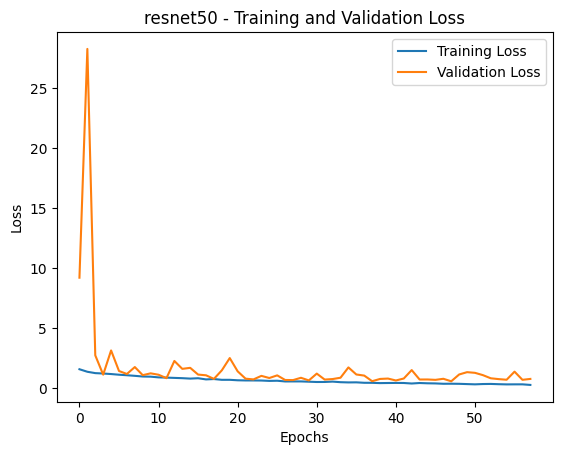

In [8]:
# resnet50 model training
resnet50_model = train_model('resnet50', X_train, y_train, X_val, y_val)

In [9]:
# evaluation for both train & test of resnet50
resnet50_cm_train, resnet50_precision_train, resnet50_recall_train, resnet50_accuracy_train, resnet50_f1_train = evaluate_model(resnet50_model, X_train, y_train)
resnet50_cm_test, resnet50_precision_test, resnet50_recall_test, resnet50_accuracy_test, resnet50_f1_test = evaluate_model(resnet50_model, X_test, y_test)



In [10]:
# For the training dataset
print("Training dataset:")
print("Confusion matrix: \n", resnet50_cm_train)
print("Precision: {:.2f}".format(resnet50_precision_train))
print("Recall: {:.2f}".format(resnet50_recall_train))
print("Accuracy: {:.2f}".format(resnet50_accuracy_train))
print("F1-score: {:.2f}".format(resnet50_f1_train))

# For the test dataset
print("\nTest dataset:")
print("Confusion matrix: \n", resnet50_cm_test)
print("Precision: {:.2f}".format(resnet50_precision_test))
print("Recall: {:.2f}".format(resnet50_recall_test))
print("Accuracy: {:.2f}".format(resnet50_accuracy_test))
print("F1-score: {:.2f}".format(resnet50_f1_test))


Training dataset:
Confusion matrix: 
 [[451   1  11  44   8]
 [  4 294   4   7  35]
 [  7   4 405  12  16]
 [  1   9  34 440  16]
 [  1   3  10  17 462]]
Precision: 0.90
Recall: 0.89
Accuracy: 0.89
F1-score: 0.89

Test dataset:
Confusion matrix: 
 [[91  1  6  8  4]
 [ 6 48  3  3 14]
 [ 4  3 77  2  9]
 [ 1  1  7 95  4]
 [ 2  1  4  5 93]]
Precision: 0.83
Recall: 0.82
Accuracy: 0.82
F1-score: 0.82


Epoch 1/60
460/460 [==============================] - 43s 77ms/step - loss: 0.8902 - accuracy: 0.6664 - val_loss: 0.3680 - val_accuracy: 0.8760

Epoch 00001: val_loss improved from inf to 0.36797, saving model to efficientnet_b0_best_weights.h5


C:\Users\kaiyi\anaconda3\envs\ts\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/60
460/460 [==============================] - 32s 70ms/step - loss: 0.6485 - accuracy: 0.7748 - val_loss: 0.8100 - val_accuracy: 0.8313

Epoch 00002: val_loss did not improve from 0.36797
Epoch 3/60
460/460 [==============================] - 33s 72ms/step - loss: 0.5206 - accuracy: 0.8201 - val_loss: 1.6777 - val_accuracy: 0.7337

Epoch 00003: val_loss did not improve from 0.36797
Epoch 4/60
460/460 [==============================] - 32s 70ms/step - loss: 0.5123 - accuracy: 0.8293 - val_loss: 0.6714 - val_accuracy: 0.8150

Epoch 00004: val_loss did not improve from 0.36797
Epoch 5/60
460/460 [==============================] - 32s 69ms/step - loss: 0.4312 - accuracy: 0.8550 - val_loss: 0.5606 - val_accuracy: 0.8516

Epoch 00005: val_loss did not improve from 0.36797
Epoch 6/60
460/460 [==============================] - 32s 69ms/step - loss: 0.4058 - accuracy: 0.8650 - val_loss: 0.4329 - val_accuracy: 0.8638

Epoch 00006: val_loss did not improve from 0.36797
Epoch 7/60
460/460 [

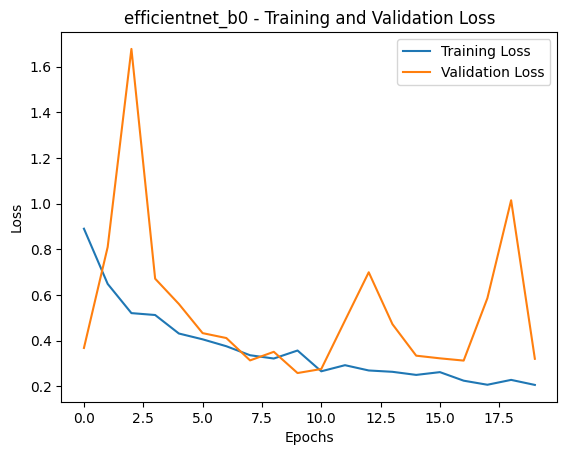

Evaluation on Training Dataset:
Confusion matrix: 
 [[486   9   1  11   8]
 [  0 316   3   4  21]
 [  0   1 424   8  11]
 [  1   3   0 493   3]
 [  0   4   2   6 481]]
Precision: 0.96
Recall: 0.96
Accuracy: 0.96
F1-score: 0.96

Evaluation on Test Dataset:

Test dataset (EfficientNetB0):
Confusion matrix: 
 [[ 94   5   3   5   3]
 [  0  66   3   1   4]
 [  0   2  78  11   4]
 [  1   1   1 104   1]
 [  0   2   1   9  93]]
Precision: 0.89
Recall: 0.88
Accuracy: 0.88
F1-score: 0.88


In [11]:
efficientnet_b0_model = train_model('efficientnet_b0', X_train, y_train, X_val, y_val)

print("Evaluation on Training Dataset:")
efficientnet_b0_cm_train, efficientnet_b0_precision_train, efficientnet_b0_recall_train, efficientnet_b0_accuracy_train, efficientnet_b0_f1_train = evaluate_model(efficientnet_b0_model, X_train, y_train)
print("Confusion matrix: \n", efficientnet_b0_cm_train)
print("Precision: {:.2f}".format(efficientnet_b0_precision_train))
print("Recall: {:.2f}".format(efficientnet_b0_recall_train))
print("Accuracy: {:.2f}".format(efficientnet_b0_accuracy_train))
print("F1-score: {:.2f}".format(efficientnet_b0_f1_train))


print("\nEvaluation on Test Dataset:")
efficientnet_b0_cm_test, efficientnet_b0_precision_test, efficientnet_b0_recall_test, efficientnet_b0_accuracy_test, efficientnet_b0_f1_test = evaluate_model(efficientnet_b0_model, X_test, y_test)
print("\nTest dataset (EfficientNetB0):")
print("Confusion matrix: \n", efficientnet_b0_cm_test)
print("Precision: {:.2f}".format(efficientnet_b0_precision_test))
print("Recall: {:.2f}".format(efficientnet_b0_recall_test))
print("Accuracy: {:.2f}".format(efficientnet_b0_accuracy_test))
print("F1-score: {:.2f}".format(efficientnet_b0_f1_test))


Epoch 1/60
460/460 [==============================] - 26s 52ms/step - loss: 7.5255 - accuracy: 0.2182 - val_loss: 1.6042 - val_accuracy: 0.2236

Epoch 00001: val_loss improved from inf to 1.60416, saving model to vgg16_best_weights.h5
Epoch 2/60
460/460 [==============================] - 21s 45ms/step - loss: 1.6030 - accuracy: 0.2143 - val_loss: 1.6015 - val_accuracy: 0.2236

Epoch 00002: val_loss improved from 1.60416 to 1.60155, saving model to vgg16_best_weights.h5
Epoch 3/60
460/460 [==============================] - 21s 45ms/step - loss: 1.6012 - accuracy: 0.2178 - val_loss: 1.6006 - val_accuracy: 0.2236

Epoch 00003: val_loss improved from 1.60155 to 1.60055, saving model to vgg16_best_weights.h5
Epoch 4/60
460/460 [==============================] - 21s 45ms/step - loss: 2.1717 - accuracy: 0.2165 - val_loss: 1.6000 - val_accuracy: 0.2236

Epoch 00004: val_loss improved from 1.60055 to 1.60004, saving model to vgg16_best_weights.h5
Epoch 5/60
460/460 [============================

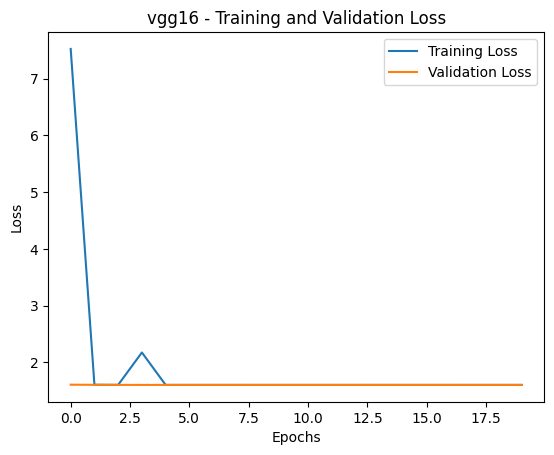

In [12]:
# vgg16 model trianing

vgg16_model = train_model('vgg16', X_train, y_train, X_val, y_val)

In [13]:
print("Evaluation on Training Dataset:")
vgg16_cm_train, vgg16_precision_train, vgg16_recall_train, vgg16_accuracy_train, vgg16_f1_train = evaluate_model(vgg16_model, X_train, y_train)
print("Confusion matrix: \n", vgg16_cm_train)
print("Precision: {:.2f}".format(vgg16_precision_train))
print("Recall: {:.2f}".format(vgg16_recall_train))
print("Accuracy: {:.2f}".format(vgg16_accuracy_train))
print("F1-score: {:.2f}".format(vgg16_f1_train))

print("\nEvaluation on Test Dataset:")
vgg16_cm_test, vgg16_precision_test, vgg16_recall_test, vgg16_accuracy_test, vgg16_f1_test = evaluate_model(vgg16_model, X_test, y_test)
print("Confusion matrix: \n", vgg16_cm_test)
print("Precision: {:.2f}".format(vgg16_precision_test))
print("Recall: {:.2f}".format(vgg16_recall_test))
print("Accuracy: {:.2f}".format(vgg16_accuracy_test))
print("F1-score: {:.2f}".format(vgg16_f1_test))

Evaluation on Training Dataset:


C:\Users\kaiyi\anaconda3\envs\ts\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix: 
 [[515   0   0   0   0]
 [344   0   0   0   0]
 [444   0   0   0   0]
 [500   0   0   0   0]
 [493   0   0   0   0]]
Precision: 0.05
Recall: 0.22
Accuracy: 0.22
F1-score: 0.08

Evaluation on Test Dataset:
Confusion matrix: 
 [[110   0   0   0   0]
 [ 74   0   0   0   0]
 [ 95   0   0   0   0]
 [108   0   0   0   0]
 [105   0   0   0   0]]
Precision: 0.05
Recall: 0.22
Accuracy: 0.22
F1-score: 0.08


C:\Users\kaiyi\anaconda3\envs\ts\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Part f

In [12]:
def train_model(model_name, X_train, y_train, X_val, y_val, epochs=None):
    model = create_model(model_name)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    checkpoint_filepath = f"{model_name}_best_weights.h5"
    model_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    if epochs is None:
        history = model.fit(datagen.flow(X_train, y_train, batch_size=5), epochs=60, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])
        best_epoch = early_stopping.stopped_epoch
        model.load_weights(checkpoint_filepath)

        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'{model_name} - Training and Validation Loss')
        plt.legend()
        plt.show()
    else:
        X_combined = np.concatenate((X_train, X_val), axis=0)
        y_combined = np.concatenate((y_train, y_val), axis=0)

        history = model.fit(datagen.flow(X_combined, y_combined, batch_size=5), epochs=epochs)

    # Save the model with the correct name
    model.save(f"{model_name}.h5")

    return model


In [12]:
resnet50_f = train_model('resnet50', X_train, y_train, X_val, y_val, epochs=58) #58, epoch used in part e as limit

Epoch 1/58
558/558 [==============================] - 36s 57ms/step - loss: 1.5196 - accuracy: 0.4096
Epoch 2/58
558/558 [==============================] - 32s 57ms/step - loss: 1.2382 - accuracy: 0.5190
Epoch 3/58
558/558 [==============================] - 31s 56ms/step - loss: 1.1366 - accuracy: 0.5560
Epoch 4/58
558/558 [==============================] - 31s 55ms/step - loss: 1.0314 - accuracy: 0.6044
Epoch 5/58
558/558 [==============================] - 31s 55ms/step - loss: 0.9746 - accuracy: 0.6320
Epoch 6/58
558/558 [==============================] - 31s 55ms/step - loss: 0.9106 - accuracy: 0.6718
Epoch 7/58
558/558 [==============================] - 31s 56ms/step - loss: 0.8589 - accuracy: 0.6901
Epoch 8/58
558/558 [==============================] - 30s 55ms/step - loss: 0.8565 - accuracy: 0.6923
Epoch 9/58
558/558 [==============================] - 31s 55ms/step - loss: 0.8454 - accuracy: 0.6980
Epoch 10/58
558/558 [==============================] - 30s 54ms/step - loss: 0.790

C:\Users\kaiyi\anaconda3\envs\ts\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [13]:
efficientnet_f = train_model('efficientnet_b0', X_train, y_train, X_val, y_val, epochs=20) #20

Epoch 1/20
558/558 [==============================] - 47s 71ms/step - loss: 0.8467 - accuracy: 0.6948
Epoch 2/20
558/558 [==============================] - 38s 69ms/step - loss: 0.6207 - accuracy: 0.7869
Epoch 3/20
558/558 [==============================] - 38s 69ms/step - loss: 0.5035 - accuracy: 0.8271
Epoch 4/20
558/558 [==============================] - 39s 69ms/step - loss: 0.4541 - accuracy: 0.8451
Epoch 5/20
558/558 [==============================] - 39s 69ms/step - loss: 0.4062 - accuracy: 0.8615
Epoch 6/20
558/558 [==============================] - 38s 69ms/step - loss: 0.3727 - accuracy: 0.8676
Epoch 7/20
558/558 [==============================] - 39s 70ms/step - loss: 0.3374 - accuracy: 0.8777
Epoch 8/20
558/558 [==============================] - 39s 69ms/step - loss: 0.3721 - accuracy: 0.8727
Epoch 9/20
558/558 [==============================] - 39s 69ms/step - loss: 0.3160 - accuracy: 0.8920
Epoch 10/20
558/558 [==============================] - 39s 69ms/step - loss: 0.301

In [9]:
vgg16_f = train_model('vgg16', X_train, y_train, X_val, y_val, epochs=20)#20

Epoch 1/20
558/558 [==============================] - 31s 47ms/step - loss: 1.8752 - accuracy: 0.2220
Epoch 2/20
558/558 [==============================] - 24s 44ms/step - loss: 1.6146 - accuracy: 0.2152
Epoch 3/20
558/558 [==============================] - 25s 44ms/step - loss: 1.6015 - accuracy: 0.2188
Epoch 4/20
558/558 [==============================] - 25s 44ms/step - loss: 1.6004 - accuracy: 0.2242
Epoch 5/20
558/558 [==============================] - 27s 48ms/step - loss: 1.6003 - accuracy: 0.2242
Epoch 6/20
558/558 [==============================] - 24s 44ms/step - loss: 1.6002 - accuracy: 0.2242
Epoch 7/20
558/558 [==============================] - 24s 43ms/step - loss: 1.6002 - accuracy: 0.2242
Epoch 8/20
558/558 [==============================] - 24s 43ms/step - loss: 1.8208 - accuracy: 0.2256
Epoch 9/20
558/558 [==============================] - 25s 45ms/step - loss: 1.6001 - accuracy: 0.2242
Epoch 10/20
558/558 [==============================] - 27s 48ms/step - loss: 1.600

In [13]:
# extract L equally spaced frames from videos
import cv2
video_path='../Data/Sport Videos'
def extract_frames(video_path, L):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, L, dtype=int)

    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

    cap.release()
    return frames


In [14]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
import random

def preprocess_image(image, model_name, target_size=(224, 224)):
    image = cv2.resize(image, target_size)

    # Augmentation parameters
    rotation_range = 20
    zoom_range = 0.15
    width_shift_range = 0.2
    height_shift_range = 0.2
    shear_range = 0.15
    horizontal_flip = True

    # Apply rotation
    angle = np.random.uniform(-rotation_range, rotation_range)
    M = cv2.getRotationMatrix2D((target_size[1] // 2, target_size[0] // 2), angle, 1)
    image = cv2.warpAffine(image, M, target_size)

    # Apply width and height shift
    tx = np.random.uniform(-width_shift_range, width_shift_range) * target_size[1]
    ty = np.random.uniform(-height_shift_range, height_shift_range) * target_size[0]
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    image = cv2.warpAffine(image, M, target_size)

    # Apply shear transformation
    shear = np.random.uniform(-shear_range, shear_range)
    M = np.float32([[1, -np.sin(shear), 0], [0, np.cos(shear), 0]])
    image = cv2.warpAffine(image, M, target_size)

    # Apply zoom
    zoom = 1 + np.random.uniform(-zoom_range, zoom_range)
    image = cv2.resize(image, None, fx=zoom, fy=zoom)
    crop_size = (min(image.shape[0], target_size[0]), min(image.shape[1], target_size[1]))
    image = image[0:crop_size[0], 0:crop_size[1]]

    # Horizontal flip
    if horizontal_flip and random.random() < 0.5:
        image = cv2.flip(image, 1)

    # Resize image to target size if necessary
    if image.shape[:2] != target_size:
        image = cv2.resize(image, target_size)

    # Convert to array
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    # Preprocess input for the specific model
    if model_name == 'resnet50_f':
        image = preprocess_input_resnet50(image)
    elif model_name == 'efficientnet_f':
        image = preprocess_input_efficientnet(image)
    elif model_name == 'vgg16_f':
        image = preprocess_input_vgg16(image)
    
    image = np.squeeze(image,axis=0)
    #else:
     #   raise ValueError("Invalid model name. Choose from 'trained_resnet50', 'trained_efficientnet_b0','trained_vgg16'.")

    return image


In [15]:
# Preprocess the extracted frames
def process_video_frames(model_name,model, frames):
    preprocessed_frames = [preprocess_image(frame,model) for frame in frames]
    predictions = model.predict(np.array(preprocessed_frames))
    return np.mean(predictions, axis=0)


In [16]:
def evaluate_model(model_name, model, video_path, L):
    y_true = []
    y_pred = []

    for subdir, dirs, files in os.walk(video_path):
        for file in files:
            video_path = os.path.join(subdir, file)
            label = os.path.basename(subdir)
            frames = extract_frames(video_path, L)
            preprocessed_frames = [preprocess_image(frame, model_name) for frame in frames]

            avg_probabilities = process_video_frames(model_name,model, preprocessed_frames)

            y_true.append(label_to_index[label])
            y_pred.append(np.argmax(avg_probabilities))

    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Results for {model_name}:")
    print("Confusion Matrix:\n", cm)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print('-' * 30)

In [17]:
import os
from tensorflow.keras.models import load_model
import gc
import tensorflow as tf
from tensorflow.keras import backend as K

# Clear GPU memory
tf.compat.v1.reset_default_graph()
K.clear_session()
gc.collect()

!nvidia-smi

Mon May  8 16:18:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.56       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   36C    P8     7W / 350W |  12087MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
# !pip install gpustat

In [19]:
import gpustat

stats = gpustat.GPUStatCollection.new_query()
for gpu in stats.gpus:
    print(f"GPU ID: {gpu.index}")
    print(f"GPU Name: {gpu.name}")
    print(f"GPU Memory Total: {gpu.memory_total} MiB")
    print(f"GPU Memory Used: {gpu.memory_used} MiB")
    print(f"GPU Memory Free: {gpu.memory_free} MiB")
    print("-" * 30)


GPU ID: 0
GPU Name: NVIDIA GeForce RTX 3080 Ti
GPU Memory Total: 12288 MiB
GPU Memory Used: 12087 MiB
GPU Memory Free: 201 MiB
------------------------------


In [20]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Load models
current_working_directory = os.getcwd()

resnet50_f_path = os.path.join(current_working_directory, "resnet50.h5")
efficientnet_f_path = os.path.join(current_working_directory, "efficientnet_b0.h5")
vgg16_f_path = os.path.join(current_working_directory, "vgg16.h5")

resnet50_f = load_model(resnet50_f_path)
efficientnet_f = load_model(efficientnet_f_path)
vgg16_f = load_model(vgg16_f_path)



In [21]:
# Evaluate models
video_labels = ['BaseballPitch', 'Basketball', 'Fencing', 'TennisSwing', 'VolleyballSpiking']
label_to_index = {label: index for index, label in enumerate(video_labels)}

evaluate_model('resnet50', resnet50_f, video_path, L=100)
tf.compat.v1.reset_default_graph()
K.clear_session()



Results for resnet50:
Confusion Matrix:
 [[140   0   0  10   0]
 [ 57   0  59  21   0]
 [ 46   0  38  27   0]
 [ 65   0  34  68   0]
 [ 50   0  58   6   2]]
Precision: 0.41557559651227366
Recall: 0.3641703377386197
Accuracy: 0.3641703377386197
F1 Score: 0.28001356088824814
------------------------------


C:\Users\yyhba\anaconda3\envs\lx\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
current_working_directory = os.getcwd()
video_labels = ['BaseballPitch', 'Basketball', 'Fencing', 'TennisSwing', 'VolleyballSpiking']
label_to_index = {label: index for index, label in enumerate(video_labels)}

evaluate_model('efficientnet_b0', efficientnet_f, video_path, L=99)
tf.compat.v1.reset_default_graph()
K.clear_session()

Results for efficientnet_b0:
Confusion Matrix:
 [[ 69   0  25  56   0]
 [  4   0 107  26   0]
 [ 22   0  87   2   0]
 [ 38   0  71  58   0]
 [  1   0 105  10   0]]
Precision: 0.24289367319603283
Recall: 0.3142437591776799
Accuracy: 0.3142437591776799
F1 Score: 0.2522533878784773
------------------------------


C:\Users\yyhba\anaconda3\envs\lx\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
current_working_directory = os.getcwd()
video_labels = ['BaseballPitch', 'Basketball', 'Fencing', 'TennisSwing', 'VolleyballSpiking']
label_to_index = {label: index for index, label in enumerate(video_labels)}

vgg16_f_path = os.path.join(current_working_directory, "vgg16.h5")
vgg16_f = load_model(vgg16_f_path)
evaluate_model('vgg16', vgg16_f, video_path, L=99)
tf.compat.v1.reset_default_graph()
K.clear_session()

Results for vgg16:
Confusion Matrix:
 [[150   0   0   0   0]
 [137   0   0   0   0]
 [111   0   0   0   0]
 [167   0   0   0   0]
 [116   0   0   0   0]]
Precision: 0.04851636942304333
Recall: 0.22026431718061673
Accuracy: 0.22026431718061673
F1 Score: 0.07951780403632373
------------------------------


C:\Users\yyhba\anaconda3\envs\lx\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
cwd = os.getcwd()
files = os.listdir(cwd)
h5_files = [file for file in files if file.endswith('.h5')]
h5_files

['efficientnet_b0.h5',
 'efficientnet_b0_best_weights.h5',
 'resnet50.h5',
 'resnet50_best_weights.h5',
 'vgg16.h5',
 'vgg16_best_weights.h5']